# Условия задачи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Нам необходимо разработать модель, которая будет предсказывать намерение клиента отключиться от оператора. В качестве метрики оценки модели должен выступать AUC, который в идеале должен быть больше 0.88 на тестовых данных. Также необходимо вывести долю правильных ответов итоговой модели.

Импорт всех библиотек, используемых в проекте.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats

from sklearn.ensemble        import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.metrics         import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils           import shuffle

from tensorflow                  import keras
from tensorflow.keras            import initializers
from tensorflow.keras.optimizers import Adam

from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier 

import warnings
warnings.filterwarnings('ignore') 

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(palette="muted")

Разделим выполнение проект на следующие части: (на данный момент проведен только исследовательский анализ данных)

<a id='step'></a>
### [**Часть 1.** Исследовательскй анализ данных](#step_1)
* [1.1. Контракты.](#step_1_1)
* [1.2. Интернет.](#step_1_2)
* [1.3. Данные о клиентах.](#step_1_3)
* [1.4. Телефония.](#step_1_4)
* [1.5. Общая информация.](#step_1_5)

* [План дальнейших работ.](#step_99)
* [Вопросы тимлиду.](#step_999)

### [**Часть 2.** Подготовка данных к обучению моделей](#step_2)
### [**Часть 3.** Обучение моделей и подбор наилучших гиперпараметров](#step_3)
### [**Часть 4.** Проверка моделей на тестовых данных](#step_4)
### [**Часть 5.** Общий вывод](#step_5)

## **Часть 1.** Исследовательскй анализ данных <a id='step_1'></a> 
#### [**Оглавление**](#step)

В данной части работы изучим предоставленные датасеты, преобразуем данные в удобный нам вид, сделаем выводы о необходимости или его отсутствии использования некоторых признаков.

### 1.1 Контракты <a id='step_1_1'></a> 

Загружаем датасет `contract` и изучаем его. Выведем первые пять объектов датасета и информацию о нем.

In [2]:
#contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract = pd.read_csv('datasets/contract.csv')
display(contract.head())
print(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


Датасет состоит из 8 столбцов и 7043 строк, не содержит явных пропусков. Данные имеют следующие признаки:

- **customerID** — ID клиента
- **BeginDate** — дата подключения к провайдеру
- **EndDate** — дата отключения от провайдера
- **Type** — тип договора
- **Paperless Billing** — электронный чек
- **Payment Method** — метод оплаты
- **Monthly Charges** — месячная оплата
- **Total Charges** — всего оплачено

По этим данным можно составить новые признаки о том, покинул ли клиент провайдера и сколько длился(длится) его договор. Также столбцы с оплатой можно привести к числовому типу данных.

В первую очередь сформируем столбец `Left` с информацией о том, покинул ли клиент провайдера. Затем сформируем столбец `MonthWith` с информацией о том сколько дней длится (если нет данных о дате отключения от провайдера) или длился (разница между датой отключения и датой подключения провайдера) договор. Затем можно удалить из датасета признаки с датами, поскольку вся полезная информация из них извлечена.

In [3]:
contract['Left'] = contract['EndDate'].apply(lambda x: 'Stay' if x == 'No' else 'Left')

today = datetime.datetime.strptime("2020-02-01","%Y-%m-%d")
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format="%Y-%m-%d")

def day_counter(row):
    """
    Функция считает длительность подключения к провайдеру, в месяцах
    """
    global today
    if row['EndDate'] == 'No':
        return int((today - row['BeginDate']).days)
    else:
        return int((datetime.datetime.strptime(row['EndDate'], "%Y-%m-%d %H:%M:%S") - row['BeginDate']).days)
    
contract['DaysWith'] = contract.apply(day_counter, axis = 1)
contract = contract.drop(['BeginDate', 'EndDate'], axis = 1)

Далее приведем данные к числовому типу в столбцах с оплатой.

In [4]:
for i in range(len(contract)):
    try:
        contract.loc[i, 'TotalCharges'] = pd.to_numeric(contract.loc[i, 'TotalCharges'])
    except:
        contract.loc[i, 'TotalCharges'] = pd.to_numeric(np.nan)
        
contract['TotalCharges']   =  contract['TotalCharges'].astype(float)
contract['MonthlyCharges'] =  contract['MonthlyCharges'].astype(float)

Взглянем на информацию о таблице после преобразований.

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Left              7043 non-null   object 
 7   DaysWith          7043 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB


В признаке `TotalCharges` имеется 11 пропусков. Попробуем выяснить откуда они взялись. Выведем объекты с пропусками.

In [6]:
contract[np.isnan(contract['TotalCharges'])]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,DaysWith
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Stay,0
753,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Stay,0
936,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Stay,0
1082,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Stay,0
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Stay,0
3331,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Stay,0
3826,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Stay,0
4380,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Stay,0
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Stay,0
6670,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,Stay,0


Судя по тому, что у всех объектов с пропусками длительность договора составляет менее месяца и они еще подключены к провайдеру можно сделать вывод о том что пропуски связаны с тем что оплата от пользователей еще не поступала, а потому эти пропуски можно заполнить нулями.

In [7]:
contract = contract.fillna(0)

Напишем функцию, которая будет строить распределения наших признаков с учетом того ушел клиент или нет, затем изучим подробно все признаки и посмотрим какие клиенты уходят чаще других.

In [8]:
def info(data):
    """
    Функция пробегает по признакам датафрейма и если тип у признака object, то смотрит строит гистограмму где признаки
    не накладываются друг на друге в пределах одного бара. В противном случае оценивается распределение и строится гистограмма,
    где признаки наложены поверх друг друга.
    """
    palette = 'tab10'
    for column in data.drop(['customerID', 'Left'], axis = 1).columns:
    
        if data[column].dtype == 'object':
            plt.figure(figsize = (8,6))
            sns.histplot(data, x = column, hue = "Left", multiple="stack", shrink=.25, palette = palette) #Построение распределения
            plt.title('Распределение ' + column)
            plt.xlabel(column)
            plt.ylabel('count')
            plt.show()
            for value in data[column].unique():
                c = len(data[(data['Left'] == 'Left') & (data[column] == value)]) / len(data[data[column] == value])
                print('Пользователей с параметром '+column+' имеющим значение '+value+' отключено: {:.2%}'.format(c))
        else:
            
            print(column)
            print()
            print(data[column].describe())
            print()
            plt.figure(figsize = (12,8))
            sns.histplot(data, x = column, hue = "Left",  element="step", bins=15, kde=False, palette = palette) #Построение распределения
            plt.title('Распределение ' + column)
            plt.xlabel(column)
            plt.ylabel('count')
            plt.show()

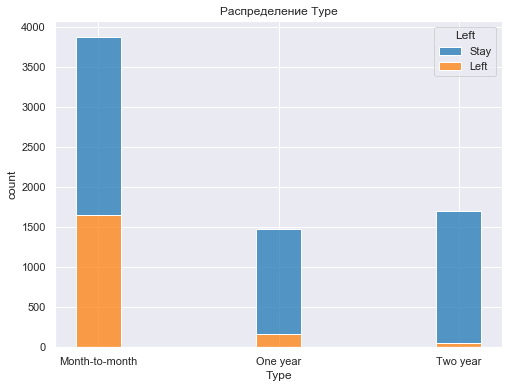

Пользователей с параметром Type имеющим значение Month-to-month отключено: 42.71%
Пользователей с параметром Type имеющим значение One year отключено: 11.27%
Пользователей с параметром Type имеющим значение Two year отключено: 2.83%


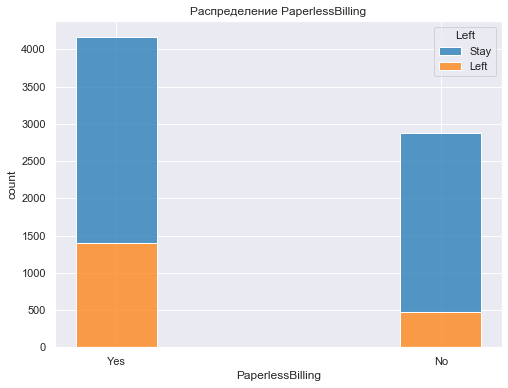

Пользователей с параметром PaperlessBilling имеющим значение Yes отключено: 33.57%
Пользователей с параметром PaperlessBilling имеющим значение No отключено: 16.33%


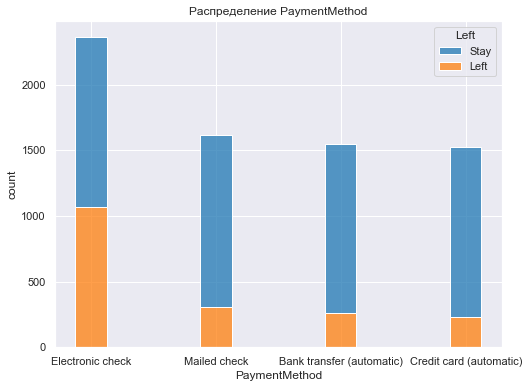

Пользователей с параметром PaymentMethod имеющим значение Electronic check отключено: 45.29%
Пользователей с параметром PaymentMethod имеющим значение Mailed check отключено: 19.11%
Пользователей с параметром PaymentMethod имеющим значение Bank transfer (automatic) отключено: 16.71%
Пользователей с параметром PaymentMethod имеющим значение Credit card (automatic) отключено: 15.24%
MonthlyCharges

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64



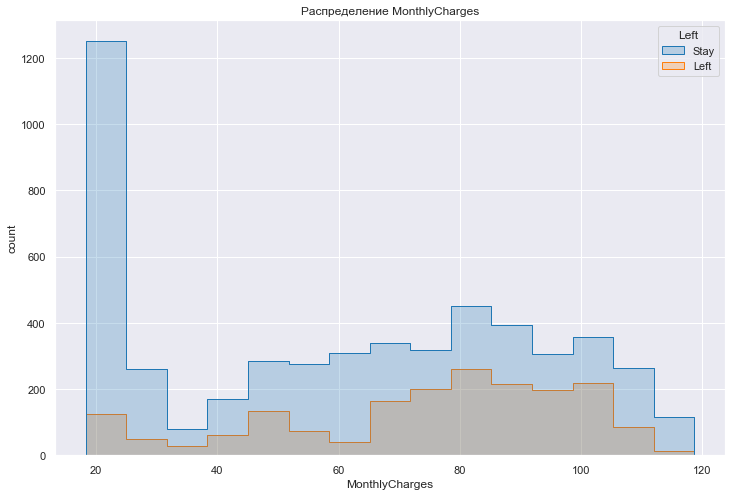

TotalCharges

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64



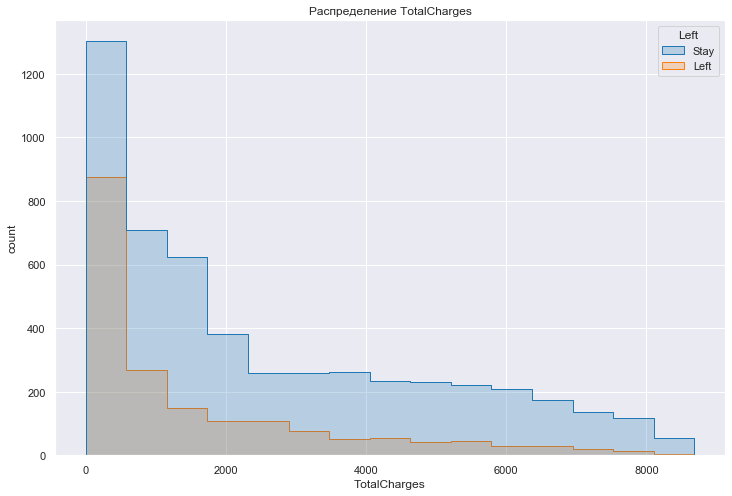

DaysWith

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: DaysWith, dtype: float64



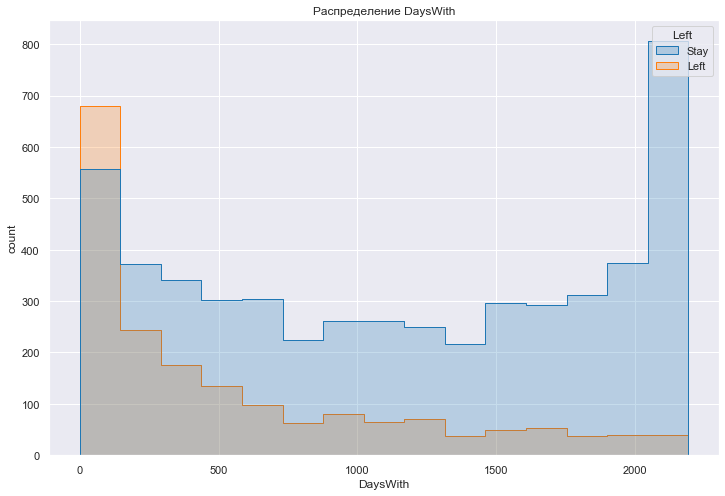

In [9]:
info(contract)

- **Тип договора** — абоненты с помесячным договором уходят гораздо чаще, чем абоненты с годичными и двухгодичными договорами;
- **Электронный чек** — абонентов получавших чек в электронном виде уходило больше, чем не получавших электронных чеков;
- **Метод оплаты** — пользователи оплачивающие электронным чеком уходят чаще, чем оплачивающие остальными методами, среди которых процент ушедших распределен примерно равномерно;
- **Месячная стоимость услуг** — видно что значительная часть пользователей имеет небольшую стоимость услуг, либо от 65 до 105 в месяц. Среди второй группы довольно много ушедших пользователей, в то время как пользователи с небольшой стоимостью услуг уходят реже;
- **Всего выплат** — чаще уходят абоненты, заплатившие немного, до 2000. Процент ушедших пользователей уменьшается с количеством выплат;
- **Длительность подключения** - здесь можно увидеть что чем дольше абонент пользуется услугами провайдера тем меньше шанс что такой пользователь уйдёт. Большое количество пользователей подключено более 4 лет.

Также исследуем корреляцию числовых признаков.

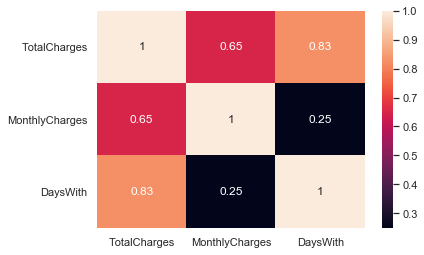

In [10]:
num = ['TotalCharges', 'MonthlyCharges', 'DaysWith']
sns.heatmap(contract[num].corr(), annot = True)
plt.show()

Как видно есть ощутимая корреляция между количеством дней, которые абонент подключен и общей суммой, которую он заплатил. В общем-то это логично, чем дольше подключен - тем больше оплатил. При обработке признаков для модели не будем учитывать `TotalCharges` т.к. между ним и `MonthlyCharges` тоже есть некоторая корреляция (что тоже логично). 

Ну и наконец, проверим гипотезы о том, что средние числовых признаков в двух категориях статистически значимо отличаются друг от друга. Для этого необходимо отклонить гипотезу о том, что их средние равны.

In [11]:
for feat in num:
    Left, Stay = [], []
    Left = contract.loc[contract['Left'] == 'Left', feat]
    Stay = contract.loc[contract['Left'] == 'Stay', feat]
    print(feat)
    print(stats.mannwhitneyu(Stay, Left, alternative = 'two-sided')[1])   

TotalCharges
5.685033866207314e-83
MonthlyCharges
3.311627651988585e-54
DaysWith
3.7766704600186777e-218


Все три вероятности значительно меньше 0.01, а значит мы можем говорить о том что средние числовых признаков для всех трех категорий статистически значимо отличаются друг от друга.

### 1.2 Интернет <a id='step_1_2'></a> 
#### [**Оглавление**](#step)

Исследуем следующие датасеты. Напишем функцию, которая будет импортировать датасет и по ID пользователя добавлять колонку с информацией о том отключиля ли он от провайдера. Затем функция будет выводить первые 5 строк датасета и общую информацию о нём.

In [12]:
def read_show(path):
    """
    Функция загружает датасет, добавляет к нему столбец с информацией о том ушел пользователь или нет,
    выводит первые 5 строк и информацию о данных
    """
    global contract
    df = pd.read_csv(path).merge(contract[['customerID', 'Left']], on = 'customerID')
    display(df.head())
    print(df.info())
    return df

Изучим с помощью нашей функции информацию об интернет-услугах.

In [13]:
#internet = read_show('/datasets/final_provider/internet.csv')
internet = read_show('datasets/internet.csv')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Left
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Stay
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Stay
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Left
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Stay
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Left


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   Left              5517 non-null   object
dtypes: object(9)
memory usage: 431.0+ KB
None


Поскольку мы знаем о том что провайдер предоставляет услуги интернета и телефонии можно сделать вывод о том что из предоставленных нам 7043 пользователей только 5517 пользуются услугами интернета. Датасет содержит 8 признаков:
- **customerID** — ID клиента
- **InternetService** — тип интернет линии
- **Online Security** — блокировка небезопасных сайтов
- **Online Backup** — облако для резервного копирования данных
- **Device Protection** — Антивирус
- **TechSupport** — выделенная линия техподдержки
- **StreamingTV** — стриминговое телевидение
- **StreamingMovies** — каталог фильмов

Все признаки имеют текстовый тип, признаки об услугах имеют два значения - предоставляется услуга или нет. Изучим каждый признак подробнее и оценим количество ушедших пользователей имеющих каждый тип услуг.

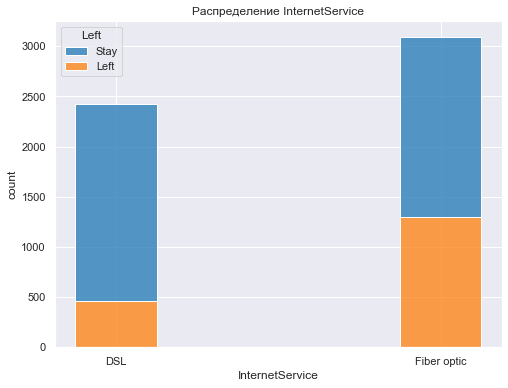

Пользователей с параметром InternetService имеющим значение DSL отключено: 18.96%
Пользователей с параметром InternetService имеющим значение Fiber optic отключено: 41.89%


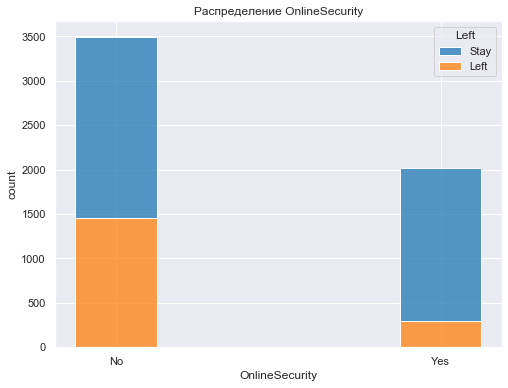

Пользователей с параметром OnlineSecurity имеющим значение No отключено: 41.77%
Пользователей с параметром OnlineSecurity имеющим значение Yes отключено: 14.61%


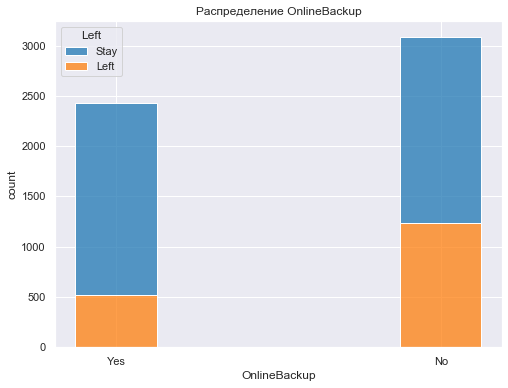

Пользователей с параметром OnlineBackup имеющим значение Yes отключено: 21.53%
Пользователей с параметром OnlineBackup имеющим значение No отключено: 39.93%


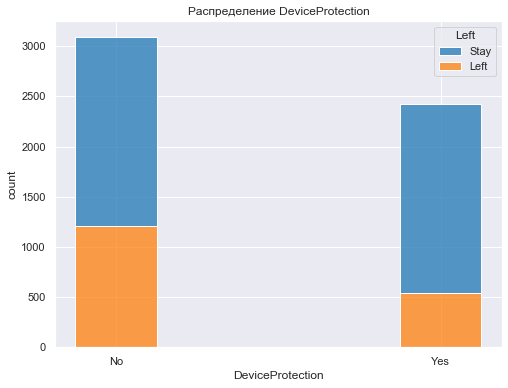

Пользователей с параметром DeviceProtection имеющим значение No отключено: 39.13%
Пользователей с параметром DeviceProtection имеющим значение Yes отключено: 22.50%


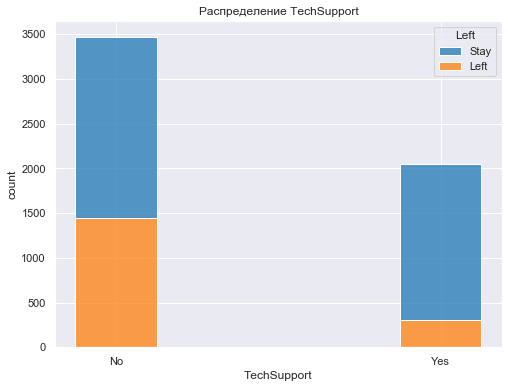

Пользователей с параметром TechSupport имеющим значение No отключено: 41.64%
Пользователей с параметром TechSupport имеющим значение Yes отключено: 15.17%


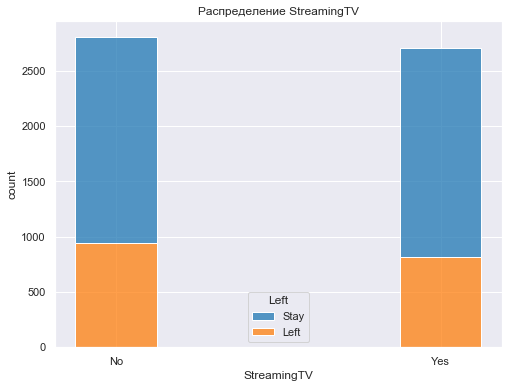

Пользователей с параметром StreamingTV имеющим значение No отключено: 33.52%
Пользователей с параметром StreamingTV имеющим значение Yes отключено: 30.07%


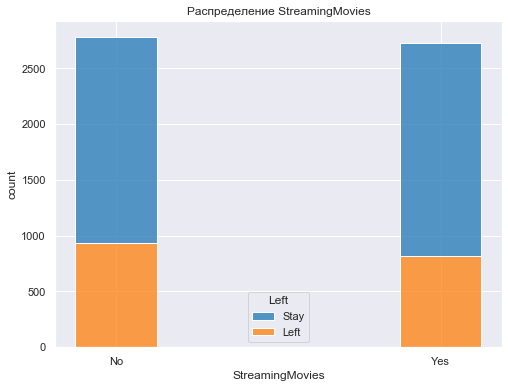

Пользователей с параметром StreamingMovies имеющим значение No отключено: 33.68%
Пользователей с параметром StreamingMovies имеющим значение Yes отключено: 29.94%


In [14]:
info(internet)

Больший процент ушедших среди абонентов подключенных по оптической линии. Пользователи подключившие услуги блокировка небезопасных сайтов, облако для резервного копирования данных, антивирус и выделенная линия техподдержки уходят реже, чем пользователи не подключавшие данные услуги. В то время как пользователи использующие и не использущие услуги стримингового телевидения и каталог фильмов распределены примерно 50/50 и процент ушедших пользователей в обеих категориях обеих услуг примерно равны из чего можно сделать предположение о том что эти услуги не оказывают влияние на поведение пользователей.

### 1.3 Данные о клиентах<a id='step_1_3'></a> 
#### [**Оглавление**](#step)

Импортируем и рассмотрим датасет с информацией о самих пользователях.

In [15]:
#personal = read_show('/datasets/final_provider/personal.csv')
personal = read_show('datasets/personal.csv')

,customerID,gender,SeniorCitizen,Partner,Dependents,Left
0,7590-VHVEG,Female,0,Yes,No,Stay
1,5575-GNVDE,Male,0,No,No,Stay
2,3668-QPYBK,Male,0,No,No,Left
3,7795-CFOCW,Male,0,No,No,Stay
4,9237-HQITU,Female,0,No,No,Left


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
 5   Left           7043 non-null   object
dtypes: int64(1), object(5)
memory usage: 385.2+ KB
None


Датасет содержит информацию о всех 7043 клиентах и имеет 4 признака (помимо ID и добавленной информации об отключении):
- **gender** — пол клиента
- **SeniorCitizen** — пенсионер
- **Partner** — в браке
- **Dependents** — наличие детей.

Признак `SeniorCitizen` представлен в числовом виде. Посмотрим какие он принимает значения.

In [16]:
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

Бинарная величина. Заменим значения на аналогичные другим колонкам *Yes* и *No*. Выведем распределения для каждого параметра.

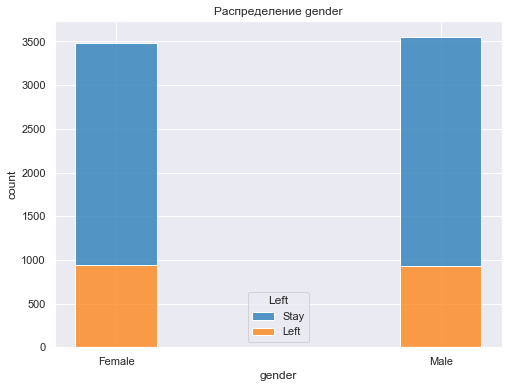

Пользователей с параметром gender имеющим значение Female отключено: 26.92%
Пользователей с параметром gender имеющим значение Male отключено: 26.16%


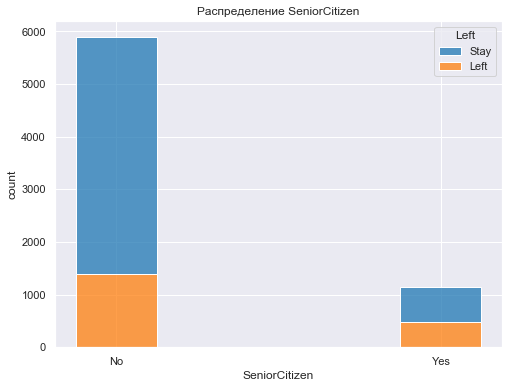

Пользователей с параметром SeniorCitizen имеющим значение No отключено: 23.61%
Пользователей с параметром SeniorCitizen имеющим значение Yes отключено: 41.68%


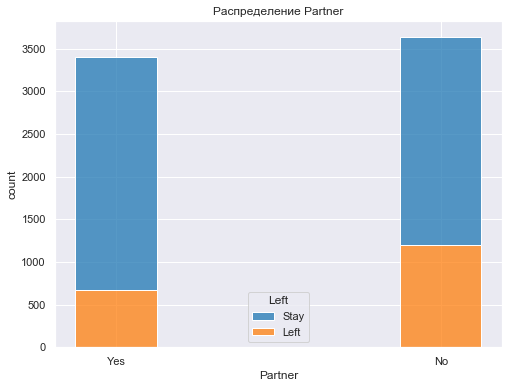

Пользователей с параметром Partner имеющим значение Yes отключено: 19.66%
Пользователей с параметром Partner имеющим значение No отключено: 32.96%


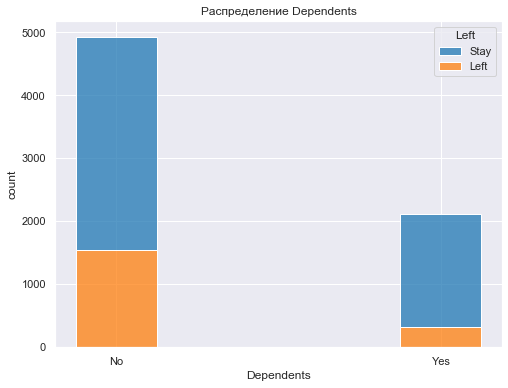

Пользователей с параметром Dependents имеющим значение No отключено: 31.28%
Пользователей с параметром Dependents имеющим значение Yes отключено: 15.45%


In [17]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].apply(lambda x: "Yes" if x == 1 else "No")
info(personal)

Распределение пользователей по их полу примерно 50 на 50, количество отключившихся пользователей в обеих категориях очень близко, можно предположить что этот фактор не влияет на поведение. Для всех остальных категорий процент отключившихся пользователей различен: для Partner и Dependents больше отключилось пользователей имеющих значение *No*, для SeniorCitizen - *Yes*.

### 1.4 Телефония <a id='step_1_4'></a> 
#### [**Оглавление**](#step)

Остался последний датасет с информацией о телефонии.

In [18]:
#phone = read_show('/datasets/final_provider/phone.csv')
phone = read_show('datasets/phone.csv')

,customerID,MultipleLines,Left
0,5575-GNVDE,No,Stay
1,3668-QPYBK,No,Left
2,9237-HQITU,No,Left
3,9305-CDSKC,Yes,Left
4,1452-KIOVK,Yes,Stay


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   Left           6361 non-null   object
dtypes: object(3)
memory usage: 198.8+ KB
None


Датасет содержит информацию о 6361 клиенте, подключенном к телефону. Можно сделать о том что не все пользователи пользовались услугами телефонии нашего провайдера. Данный датасет содержит только один признак о том, было ли подключено несколько линий, или же только одна. Рассмотрим распределение этих параметров.

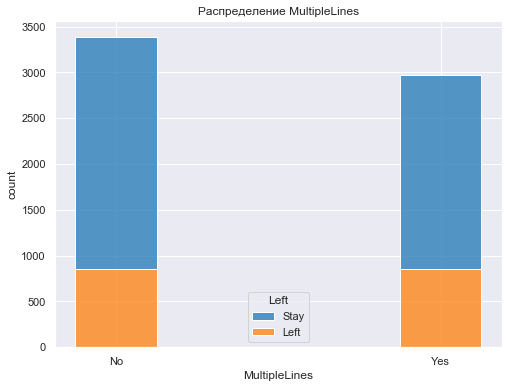

Пользователей с параметром MultipleLines имеющим значение No отключено: 25.04%
Пользователей с параметром MultipleLines имеющим значение Yes отключено: 28.61%


In [19]:
info(phone)

Как видно, процент пользователей отключившихся от провайдера в обеих категориях близок, поэтому можно предположить что признак не влияет на поведение пользователей.

### 1.5 Общая информация <a id='step_1_5'></a> 
#### [**Оглавление**](#step)

Далее посмотрим на то сколько пользователей было подключено только к интернету, сколько только к телефону, сколько и к тому и к другому и какой процент отключившихся пользователей среди этих трёх категорий. Создадим отдельный датасет, куда соберем информацию из таблиц `contract`, `internet` и `phone` и создадим отдельную колонку, которая будет заполнена так: **P** - только телефон, **I** - только интернет и **P+I** - и телефон и интернет.

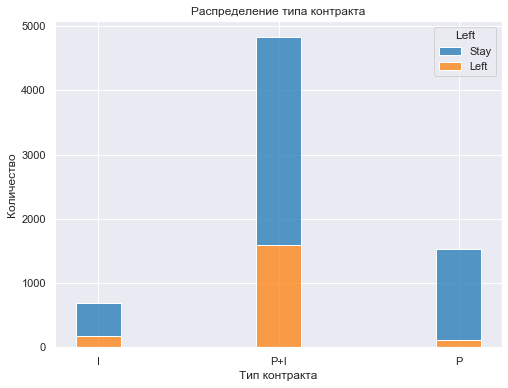

Пользователей с параметром Type имеющим значение I отключено: 24.93%
Пользователей с параметром Type имеющим значение P+I отключено: 32.80%
Пользователей с параметром Type имеющим значение P отключено: 7.40%


In [20]:
df = contract[['customerID', 'Left']].merge(internet[['customerID', 'InternetService']], on = 'customerID', how = "outer").merge(phone[['customerID', 'MultipleLines']], on = 'customerID', how = "outer").copy().fillna('ND')
df['Type'] = df.apply(lambda x: "P+I" if x.InternetService != 'ND' and x.MultipleLines != 'ND' else ("I" if x.InternetService != 'ND' else "P"), axis = 1)
plt.figure(figsize = (8,6))
sns.histplot(df, x = "Type", hue = "Left", multiple="stack", shrink=.25, palette = 'tab10') #Построение распределения
plt.title('Распределение типа контракта')
plt.xlabel('Тип контракта')
plt.ylabel('Количество')
plt.show()
for type_ in df['Type'].unique():
    c = len(df[(df['Left'] == 'Left') & (df['Type'] == type_)]) / len(df[df['Type'] == type_])
    print('Пользователей с параметром '+'Type'+' имеющим значение '+type_+' отключено: {:.2%}'.format(c))

Количество отключившихся пользователей во всех трех категориях различно. Значит это поведение тоже влияет.

## **Часть 2.** Подготовка данных к обучению моделей <a id='step_2'></a> 
#### [**Оглавление**](#step)

Для подготовки данных объединим все таблицы в одну по ID клиента. Все пропуски заполним уникальными значениями, например (*ND* - No Data), т.к. они появятся только при объединении таблиц, а значит это значение будет отображать то, что клиент в принципе не может воспользоваться такой услугой, поскольку не подключен к способу связи, к которой услуга идёт допом. Также удалим признак с общей суммой выплат клиентов, т.к. он сильно коррелирует с другими числовыми признаками.

In [21]:
internet.drop('Left', axis = 1, inplace = True)
personal.drop('Left', axis = 1, inplace = True)
phone.drop('Left', axis = 1, inplace = True)

In [22]:
#Формирование единого датасета
data = contract.merge(internet, on = 'customerID', how = 'outer').merge(personal, on = 'customerID', how = 'outer').merge(phone, on = 'customerID', how = 'outer').fillna('ND')

#Формирование столбца labels, необходимого в дальнейшем для расчета весов категориальных признаков
#И удаление признаков с ID клиента и общей суммой выплат
data['labels'] = data['Left'].apply(lambda x: 1 if x == 'Left' else 0)
data.drop(['customerID', 'TotalCharges'], axis = 1, inplace = True)
data_copy = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Left              7043 non-null   object 
 5   DaysWith          7043 non-null   int64  
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  gender            7043 non-null   object 
 14  SeniorCitizen     7043 non-null   object 
 15  Partner           7043 non-null   object 
 16  Dependents        7043 non-null   object 


Напишем функцию `scalarizator` которая будет принимать на вход признаки и таргет, разделять выборки на обучающую и тестовую, масштабировать числовые признаков с помощью MinMaxScaler'a, придавать веса категориальным признакам и выводить 4 группы подготовленных данных. Значения категориальных признаков будем заменять долей положительного класса при этом значении. Чтобы не переобучиться, разбобьем тестовую выборку на несколько частей, тогда средние для первой части будут вычисляться по 2й, 3й и 4й и т.д. Для тестовой выборки веса будем считать по всей обучающей.

In [23]:
def scalarizator(x, Y):
    num_X = x.drop('labels', axis = 1).select_dtypes(include=['int64', 'float64']).columns
    cat_X = x.select_dtypes(include = 'object').columns
    
    #Делим выборки на обучающую (_1) и тестовую (_2). Стратифицируем для равномерного распределения целевого признака.
    x_1, x_2, y_1, y_2 = train_test_split(x, Y, test_size=0.2, random_state=357, shuffle = True, stratify=Y)
    
    #Масштабируем числовые признаки
    scaler = MinMaxScaler()
    scaler.fit(x_1[num_X])
    x_1.loc[:, num_X] = scaler.transform(x_1[num_X])
    x_2.loc[:, num_X] = scaler.transform(x_2[num_X])
    
    x_1.reset_index(inplace = True) # сбрасываем индексы для нормальной отработки цикла с весами
    folds = 4                       # делим выборку на 4 подвыборки для прореживания
    x_1_copy = x_1.copy()           # создаем копию обучающей выборки для рассчета весов в тестовой
    
    for feat in cat_X:
        #Формируем пустой список весов текущего признака
        train_feat = np.array([np.nan] * x_1.shape[0])
        for i in range(folds):
            #Индексы фолда, для которого рассчитываем веса
            idx_rplc = range(x_1.shape[0])[i::folds]
            #Доли положительного класса текущего признака в оставшихся фолдах
            tm = x_1.drop(idx_rplc).groupby([feat])['labels'].mean()
            #Формирование подвыборки, текущего фолда 
            x_temp = x_1[~x_1.index.isin(x_1.drop(idx_rplc).index)]
            #Заполнение списка весами текущего фолда
            train_feat[idx_rplc] = x_temp[feat].map(tm)
        x_1[feat] = train_feat
    
    # Возвращаем индексы после прохода цикла
    x_1.set_index('index', inplace = True) 
    
    for feat in cat_X:    
        tm_test   = x_1_copy.groupby([feat])['labels'].mean()
        x_2[feat] = x_2[feat].map(tm_test)
    
    del x_1_copy
    del x_temp
    
    #удаляем целевой признак, помогавший нам искать веса
    x_1 = x_1.drop('labels', axis = 1)
    x_2 = x_2.drop('labels', axis = 1) 
    
    return x_1, x_2, y_1, y_2

Выделим из нашего датасета целевой признак и обработаем данные с помощью нашей функции

In [24]:
y = data['Left']
X = data.drop(['Left'], axis = 1)
X_train, X_test, y_train, y_test = scalarizator(X, y)

Теперь, когда мы преобразовали категориальные признаки в числовые, посмотрим корреляцию между ними. Точнее, мы будем смотреть на корреляцию весов признаков, т.е. на корреляцию того, как они влияют на целевой признак. Использовать будем обучающую выборку.

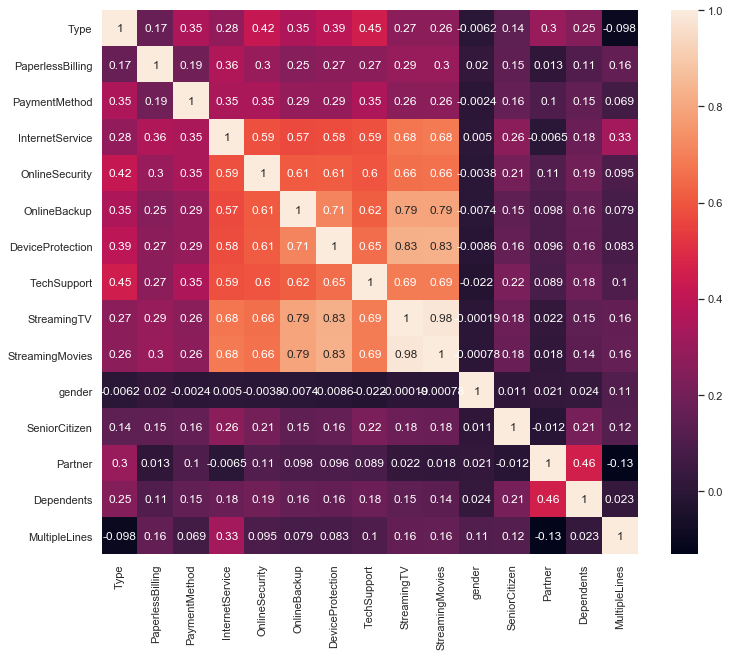

In [25]:
cat_X = X.drop('labels', axis = 1).select_dtypes(include = 'object').columns
plt.figure(figsize = (12, 10))
sns.heatmap(X_train[cat_X].corr(), annot = True)
plt.show()

Видно что в целом данные из таблицы *Internet* сильно коррелируют между собой, особенно наличие стримингового тв и онлайн кинотеатра. Тем не менее, пока удалять признаки не будем, сначала посмотрим какие из них модели посчитают наименее значимыми, после первой итерации часть удалим, а затем построим модели еще раз.

Теперь у нас есть данные, готовые к обучению моделей. В процессе обучения моделей мы можем отбрасывать или преобразовывать признаки и написанная функция нам еще может пригодиться.

## **Часть 3.** Обучение моделей и подбор наилучших гиперпараметров <a id='step_3'></a> 
#### [**Оглавление**](#step)

Проведем обучение нескольких моделей, к каждой подберем наиболее подходящие данные. Опишем алгоритм подбора:
1. Сначала для каждой модели создадим два словаря: с дефолтными значениями гиперпараметров и с набором значений для гиперпараметров, из которых мы будем подбирать лучшие. 
2. Для каждой модели будем в цикле подбирать наилучшие гиперпараметры, с учетом подобранных предыдущих. Для этого напишем функцию `funnel_param` которая будет принимать в себя словарь наборов значений гиперпараметров, имя подбираемого на данном этапе гиперпараметра и модель. Функция с помощью грид-сёрча будет подбирать наилучшее значение гиперпараметра и записывать в словарь с дефолтными значениями, таким образом у нас получится словарь с наилучшими значениями гиперпараметров для данной модели.
3. Выберем несколько моделей, давших наилучшие значения метрики, посмотрим как они оценили важность признаков, уберем наименее важные и подберем гиперпараметры для этих лучших моделей заново повторив пункты 1 и 2.

In [26]:
def funnel_param(param: dict, key, model):
    global X_train, y_train
    di = {}
    di[key] = param[key]
    gs = GridSearchCV(model, di, cv=3, n_jobs=-1, verbose=False, scoring = 'roc_auc')
    gs.fit(X_train, y_train)
    return gs.best_params_[key], gs.best_estimator_, gs.best_score_   

Использовать будем следующие модели (в скобках указаны суффиксы переменных):
1. Логистическая регрессия (*lr*)
2. Случайный лес (*rfc*)
3. Классификатор с градиентным бустингом (*gbc*)
4. Классификатор с градиентным бустингом из библиотеки **XGB** (*xgbc*)
5. Классификатор с градиентным бустингом из библиотеки **LGBM** (*lgbc*)
6. Нейронная сеть (*NNC*)

Все словари с дефолтными/лучшими значениями будут иметь префикс - *d*, словари с перечнями подбираемых значений - *dr*, наилучшая подобраная модель - *bm*, наилучшее значение метрики - *bs*.

In [27]:
d_lr = {'max_iter'    : 100, 
        'solver'      : 'newton-cg',
        'multi_class' : 'ovr',
        'C'           :1.0,
        'class_weight':None}

dp_lr = {'solver'      : ('newton-cg', 'lbfgs', 'sag'), 
         'max_iter'    : range(5, 41),
         'multi_class' :('ovr', 'multinomial'),
         'C'           :range(1, 201, 10),
         'class_weight':(None, 'balanced')}
for name in dp_lr.keys():
    lr   = LogisticRegression(**d_lr)
    d_lr[name], bm_lr, bs_lr = funnel_param(dp_lr, name, lr)
print(d_lr)

{'max_iter': 10, 'solver': 'sag', 'multi_class': 'ovr', 'C': 181, 'class_weight': 'balanced'}


In [28]:
d_rfc = {'max_features'     : 'auto',
         'class_weight'     : None,
         'max_depth'        : None,
         'n_estimators'     : 50,
         'min_samples_split': 2,
         'random_state'     : 357}

dp_rfc = {'max_features'     : ('auto', 'log2'),
          'class_weight'     : ('balanced', None),
          'max_depth'        : range(3,11),
          'n_estimators'     : range(50, 151, 10),
          'min_samples_split': range(2, 7)}

for name in dp_rfc.keys():
    rfc   = RandomForestClassifier(**d_rfc)
    d_rfc[name], bm_rfc, bs_rfc = funnel_param(dp_rfc, name, rfc)
print(d_rfc)

{'max_features': 'auto', 'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 150, 'min_samples_split': 3, 'random_state': 357}


In [29]:
d_gbc = {'learning_rate'    : 0.1,
         'n_estimators'     : 100,
         'min_samples_split': 2,
         'random_state'     : 357}

dp_gbc = {'learning_rate'    : [0.1, 0.05, 0.03, 0.01],
          'n_estimators'     : range(100, 1001, 100),
          'min_samples_split': range(2, 11)}

for name in dp_gbc.keys():
    gbc   = GradientBoostingClassifier(**d_gbc)
    d_gbc[name], bm_gbc, bs_gbc = funnel_param(dp_gbc, name, gbc)
print(d_gbc)

{'learning_rate': 0.1, 'n_estimators': 700, 'min_samples_split': 10, 'random_state': 357}


In [30]:
d_xgbc = {'learning_rate' : 0.1,
          'n_estimators': 100,
          'booster': 'gbtree',
          'max_depth':3,
          'n_jobs': -1}

dp_xgbc = {'booster': ('gbtree', 'gblinear', 'dart'),
           'learning_rate': [0.1, 0.05, 0.03],
           'n_estimators' : range(100, 1001, 100),
           'max_depth'    :range(3, 11)}

for name in dp_xgbc.keys():
    xgbc   = XGBClassifier(**d_xgbc)
    d_xgbc[name], bm_xgbc, bs_xgbc = funnel_param(dp_xgbc, name, xgbc)
print(d_xgbc)

{'learning_rate': 0.1, 'n_estimators': 900, 'booster': 'gbtree', 'max_depth': 3, 'n_jobs': -1}


In [31]:
d_lgbc = {'learning_rate' : 0.1,
          'n_estimators': 100,
          'max_depth':3,
          'n_jobs': -1}

dp_lgbc = {'learning_rate': [0.1, 0.05, 0.03],
           'n_estimators': range(100, 1001, 100),
           'max_depth':range(3, 11)}

for name in dp_lgbc.keys():
    lgbc   = LGBMClassifier(**d_lgbc)
    d_lgbc[name], bm_lgbc, bs_lgbc = funnel_param(dp_lgbc, name, lgbc)
print(d_lgbc)

{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 3, 'n_jobs': -1}


Нейросеть будем учить без подбора гиперпараметров, поскольку повторяемость результата неточна, а различия между количествами эпох и количествами нейронов не дают разницы больше случайной погрешности, то обучим одну нейросеть, состоящую из трех слоев, в первых двух по 10 нейронов, в последнем 1 с сигмоидом в качестве функции активации. Обучать будем 25 эпох, перед обучением разделим обучающие данные на тренировочные и валидационные, чтобы тестовые остались на проверку. Для её проверки отделим валидационную выборку и целевой признак из категориального превратим в числовой.

In [32]:
y_01 = y_train.apply(lambda x: 1 if x == 'Left' else 0)
X_teach, X_valid, y_teach, y_valid = train_test_split(X_train, y_01, test_size=0.25, random_state=12345, stratify = y_01)

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units = 10, input_dim = X_teach.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
model.add(keras.layers.Dense(units = 10, input_dim = X_teach.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
model.add(keras.layers.Dense(units = 1, input_dim = X_teach.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros(), activation = 'sigmoid'))
# < напишите код здесь >
optimizer = Adam(lr=0.05)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', 'AUC'])

In [34]:
model.fit(X_teach, y_teach, epochs=25, verbose=0)#, batch_size = 20) #validation_data = (X_valid, y_valid))
bs_nnc = model.evaluate(X_valid, y_valid, verbose = 0)[2]

Выведем результаты наших моделей.

In [35]:
results = pd.Series([bs_lr, bs_rfc, bs_gbc, bs_xgbc, bs_lgbc, bs_nnc], index = ['LR', 'RFC', 'GBC', 'XGBC', 'LGBC', 'NNC'])
display(results)

LR      0.838314
RFC     0.850240
GBC     0.900936
XGBC    0.889618
LGBC    0.888723
NNC     0.844500
dtype: float64

Видно что наилучшими моделями оказались модели использующие градиентный бустинг. Хуже всех показала себя линейная регрессия. Далее будем использовать только 3 лучших модели. Посмотрим какие признаки они посчитали наиболее важными.

In [36]:
# Функция преобразования шкалы в проценты, поскольку все модели дают feature_importances_ в разных масштабах
def normalizer(Z):
    return 100*(Z - Z.min()) / (Z.max() - Z.min())

In [37]:
pivot = pd.DataFrame({'Features':X_train.columns,
                      'LGBC':normalizer(pd.Series(bm_lgbc.feature_importances_)),
                      'XGBC':normalizer(bm_xgbc.feature_importances_ * 100),
                      'GBC' :normalizer(bm_gbc.feature_importances_ * 100)})
pivot.style.bar(color='#d65f5f')                      

,Features,LGBC,XGBC,GBC
0,Type,7.960433,100.000008,49.664887
1,PaperlessBilling,3.014602,5.053213,2.376054
2,PaymentMethod,8.290155,6.536784,7.202233
3,MonthlyCharges,49.128592,1.247375,26.513542
4,DaysWith,100.000000,12.701210,100.000000
5,InternetService,3.061705,50.948891,13.637055
6,OnlineSecurity,3.061705,27.101175,7.709441
7,OnlineBackup,1.554404,1.301333,1.087852
8,DeviceProtection,1.695714,1.317814,0.572945
9,TechSupport,2.355158,19.722515,6.993712


Каждая функция посчитала важность признаков по-разному. Явно 2 модели посчитали самым важным признаком длительность пребывания клиента, одна - тип договора. Те же 2 модели посчитали наименее важным признаком наличие услуги онлайн-кинотеатра. Удалим из признаков онлайн кинотеатр, стриминг тв, антивирус, облако для резервного копирования и количество детей. После этого еще раз подберем гиперпараметры для всех использованных моделей градиентного бустинга и оценим их результаты на обучающих выборках.

In [38]:
y = data['Left']
X = data.drop(['Left', 'StreamingTV', 'DeviceProtection', 'Dependents', 'OnlineBackup', 'StreamingMovies'], axis = 1)
X_train, X_test, y_train, y_test = scalarizator(X, y)

In [39]:
d_gbc = {'learning_rate'    : 0.1,
         'n_estimators'     : 100,
         'min_samples_split': 2,
         'random_state'     : 357}

dp_gbc = {'learning_rate'    : [0.1, 0.05, 0.03, 0.01],
          'n_estimators'     : range(100, 1001, 100),
          'min_samples_split': range(2, 11)}

for name in dp_gbc.keys():
    gbc   = GradientBoostingClassifier(**d_gbc)
    d_gbc[name], bm_gbc, bs_gbc = funnel_param(dp_gbc, name, gbc)
print(d_gbc)

{'learning_rate': 0.1, 'n_estimators': 1000, 'min_samples_split': 7, 'random_state': 357}


In [40]:
d_xgbc = {'learning_rate' : 0.1,
          'n_estimators': 100,
          'booster': 'gbtree',
          'max_depth':3,
          'n_jobs': -1}

dp_xgbc = {'booster': ('gbtree', 'gblinear', 'dart'),
           'learning_rate': [0.1, 0.05, 0.03],
           'n_estimators' : range(100, 1001, 100),
           'max_depth'    :range(3, 11)}

for name in dp_xgbc.keys():
    xgbc   = XGBClassifier(**d_xgbc)
    d_xgbc[name], bm_xgbc, bs_xgbc = funnel_param(dp_xgbc, name, xgbc)
print(d_xgbc)

{'learning_rate': 0.1, 'n_estimators': 1000, 'booster': 'gbtree', 'max_depth': 3, 'n_jobs': -1}


In [41]:
d_lgbc = {'learning_rate' : 0.1,
          'n_estimators': 100,
          'max_depth':3,
          'n_jobs': -1}

dp_lgbc = {'learning_rate': [0.1, 0.05, 0.03],
           'n_estimators': range(100, 1001, 100),
           'max_depth':range(3, 11)}

for name in dp_lgbc.keys():
    lgbc   = LGBMClassifier(**d_lgbc)
    d_lgbc[name], bm_lgbc, bs_lgbc = funnel_param(dp_lgbc, name, lgbc)
print(d_lgbc)

{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 3, 'n_jobs': -1}


In [42]:
results = pd.Series([bs_gbc, bs_xgbc, bs_lgbc], index = ['GBC', 'XGBC', 'LGBC'])
display(results)

GBC     0.905333
XGBC    0.892710
LGBC    0.889870
dtype: float64

Немного улучшилось качество первых двух моделей и практически не изменилось качество третьей. Осталось только проверить модели на тестовых данных.

## **Часть 4.** Проверка моделей на тестовых данных <a id='step_4'></a> 
#### [**Оглавление**](#step)

Перед проверкой моделей напишем функцию, которая используя будет обучать модель на всех обучающих данных и делать предсказание на тестовых, после чего выдавать значение метрики и данные для построения ROC-кривой.

In [43]:
def fit_pred(model):
    global X_train, X_test, y_train, y_test
    md = model
    md.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_test)[:,0]
    y_10 = y_test.apply(lambda x: 1 if x == 'Left' else 0)
    roc_x, roc_y, thresholds = roc_curve(y_10, pred_proba)
    return roc_auc_score(y_10, pred_proba), roc_x, roc_y, accuracy_score(y_test, model.predict(X_test))

Теперь с помощью этой функции построим обучим модели градиентного бустинга, сделаем предсказания и построим график их ROC-кривых и сравним значения метрики AUC.

In [44]:
gbc   = GradientBoostingClassifier(**d_gbc)
xgbc   = XGBClassifier(**d_xgbc)

d_lgbc['num_leaves'] = 2 ** d_lgbc['max_depth']
lgbc   = LGBMClassifier(**d_lgbc)

auc_gbc, gbc_x, gbc_y, acc_gbc = fit_pred(gbc)
auc_xgbc, xgbc_x, xgbc_y, acc_xgbc = fit_pred(xgbc)
auc_lgbc, lgbc_x, lgbc_y, acc_lgbc = fit_pred(lgbc)

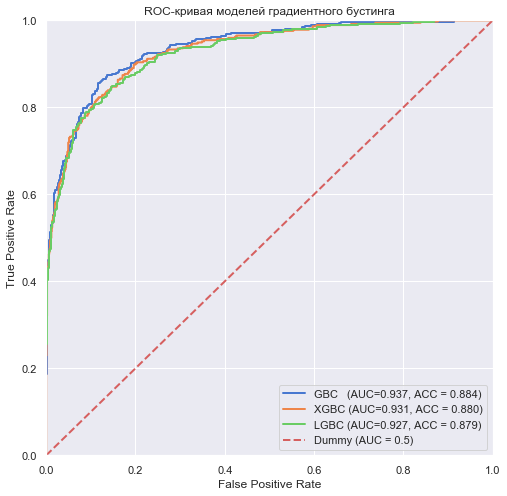

In [45]:
plt.figure(figsize = (8,8))
plt.plot(gbc_x, gbc_y, label = "GBC   (AUC={:.3f}, ACC = {:.3f})".format(auc_gbc, acc_gbc), linewidth = 2)
plt.plot(xgbc_x, xgbc_y, label = "XGBC (AUC={:.3f}, ACC = {:.3f})".format(auc_xgbc, acc_xgbc), linewidth = 2)
plt.plot(lgbc_x, lgbc_y, label = "LGBC (AUC={:.3f}, ACC = {:.3f})".format(auc_lgbc, acc_lgbc), linewidth = 2)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Dummy (AUC = 0.5)', linewidth = 2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая моделей градиентного бустинга')
plt.legend(loc = "lower right")
plt.show()

Результаты видны на графике. Наибольшая AUC метрика получилась у модели из библиотеки **SKLearn**, и она же показала наибольшую долю правильных ответов.Средняя по метрикам модель **XGBoost** и самая слабая - модель из **LGBM**. Тем не менее, все три модели показали более чем удовлетворяющее значение метрик и отличаются между собой не кардинально. При выборе модели также может сыграть важную роль время обучения, где уже **LGBM** может опередить остальные модели.

Взглянем еще раз на то, как модели оценили важность признаков.

In [46]:
pivot = pd.DataFrame({'Features':X_train.columns,
                      'LGBC':normalizer(pd.Series(lgbc.feature_importances_)),
                      'XGBC':normalizer(xgbc.feature_importances_ * 100),
                      'GBC' :normalizer(gbc.feature_importances_ * 100)})
pivot.style.bar(color='#d65f5f')    

,Features,LGBC,XGBC,GBC
0,Type,4.898336,100.000000,45.677868
1,PaperlessBilling,0.554529,5.465134,1.292090
2,PaymentMethod,7.532348,8.918379,6.755662
3,MonthlyCharges,49.815157,2.299106,28.316098
4,DaysWith,100.000000,15.323569,100.000000
5,InternetService,0.000000,41.088169,11.698841
6,OnlineSecurity,1.894640,20.596079,6.603851
7,TechSupport,2.402957,19.601442,6.066625
8,gender,2.171904,2.019684,0.654266
9,SeniorCitizen,1.247689,2.989372,0.486092


В общих чертах картина не изменилась. Интересно что одна модель посчитала признак InternetService наименее важным, в то время как другая - вторым по важности. Все модели сходятся на том что персональные данные и данные о телефонии наименее важные.

## Часть 5. Общий вывод <a id='step_5'></a> 
#### [**Оглавление**](#step)

В данной работе перед нами стояла задача создания модели прогнозирования оттока клиентов телеком-провайдера. Нам были предоставлены данные об используемых клиентами услугах, данных о заключенных ими договорах и персональных обезличенных данных. Мы провели исследование предоставленных нам датасетов, проверили корреляцию числовых признаков, оценили значимость различий их средних для двух категорий (отключившихся от провайдера и оставшихся клиентов). Затем подготовили признаки к обучению, отделили целевые и посмотрели корреляцию влияния категориальных признаков на целевой. Обучили 6 различных моделей с первичным подбором гиперпараметров, выбрали из них 3 наиболее эффективных модели, изучили оценку влияния признаков этими моделями. Затем удалили наименее влияющие на модели признаки, подобрали еще раз гиперпараметры на очищенных датасетах. После этого обучили модели заново на всех тренировочных данных и проверили их на тестовой выборке. Результаты получились следующие:

| Модель| Библиотека | Значение AUC | Значение Accuracy | 
| :---------------------- | :---------------------- | :---------------------- | :---------------------- |
| GradientBoostingClassifier | sklearn | 0.937 | 0.884 |
| XGBClassifier | XGBoost | 0.931 | 0.880 |
| LGBMClassifier | LightGBM | 0.927 | 0.879 |

Таким образом, наилучшей моделью выбрана GradientBoostingClassifier из библиотеки sklearn.